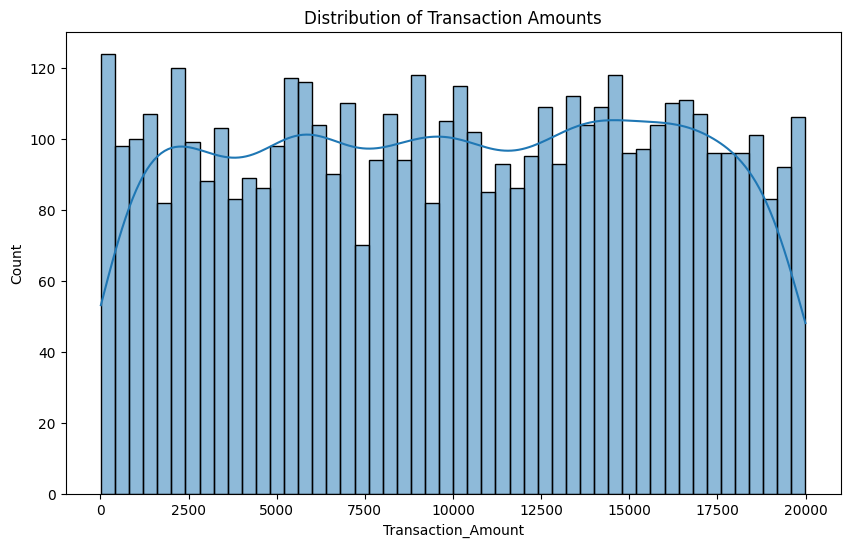

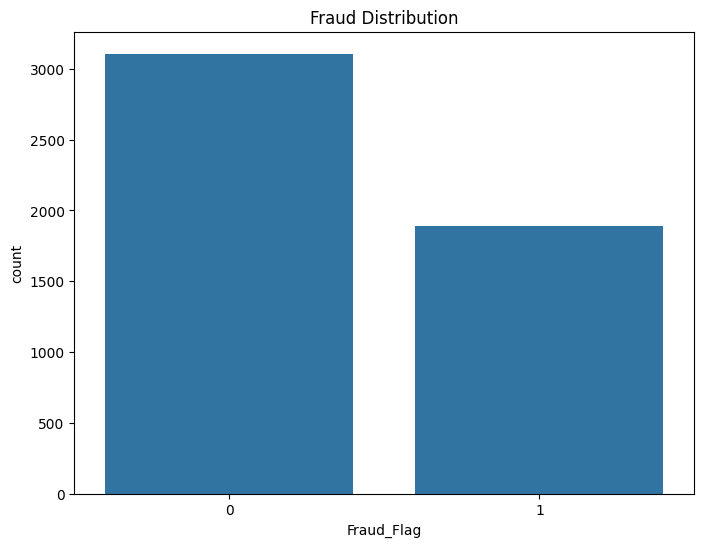

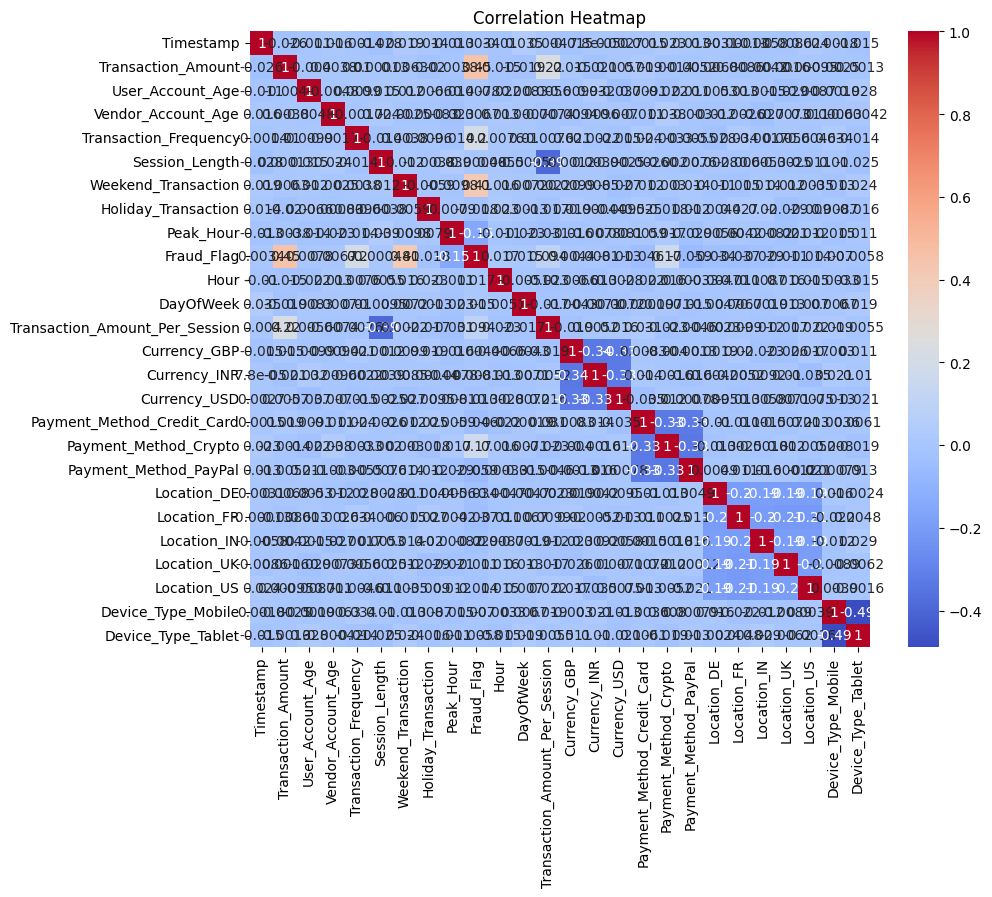

Data successfully split and scaled.


In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

def generate_realistic_data(num_samples=5000):
    np.random.seed(42)  # For reproducibility

    # Generate timestamps with realistic transaction patterns
    start_date = datetime(2024, 1, 1)
    timestamps = [start_date + timedelta(minutes=np.random.randint(0, 60*24*365)) for _ in range(num_samples)]

    # Transaction data
    data = {
        'Timestamp': timestamps,
        'Transaction_Amount': np.random.uniform(10, 20000, num_samples),
        'Currency': np.random.choice(['USD', 'EUR', 'GBP', 'INR'], num_samples),
        'Payment_Method': np.random.choice(['Credit_Card', 'Bank_Transfer', 'PayPal', 'Crypto'], num_samples),
        'User_Account_Age': np.random.randint(1, 1000, num_samples),
        'Vendor_Account_Age': np.random.randint(1, 1000, num_samples),
        'Transaction_Frequency': np.random.randint(1, 50, num_samples),
        'Session_Length': np.random.uniform(1, 300, num_samples),
        'Location': np.random.choice(['US', 'UK', 'IN', 'CN', 'DE', 'FR'], num_samples),
        'Device_Type': np.random.choice(['Mobile', 'Desktop', 'Tablet'], num_samples),
        'Weekend_Transaction': np.random.choice([0, 1], num_samples),
        'Holiday_Transaction': np.random.choice([0, 1], num_samples),
        'Peak_Hour': np.random.choice([0, 1], num_samples)
    }

    df = pd.DataFrame(data)

    # Complex logic for risk conditions
    conditions = (
        ((df['Transaction_Amount'] > 15000) & (df['Payment_Method'] == 'Crypto')) |
        ((df['User_Account_Age'] < 30) & (df['Vendor_Account_Age'] < 30)) |
        ((df['Transaction_Frequency'] > 40) & (df['Peak_Hour'] == 0)) |
        ((df['Weekend_Transaction'] == 1) & (df['Transaction_Amount'] > 10000)) |
        ((df['Location'] == 'CN') & (df['Payment_Method'] == 'Crypto'))
    )

    df['Fraud_Flag'] = np.where(conditions, 1, 0)

    # Feature Engineering
    df['Hour'] = pd.to_datetime(df['Timestamp']).dt.hour
    df['DayOfWeek'] = pd.to_datetime(df['Timestamp']).dt.dayofweek
    df['Transaction_Amount_Per_Session'] = df['Transaction_Amount'] / (df['Session_Length'] + 1)

    # Encoding categorical data
    df = pd.get_dummies(df, columns=['Currency', 'Payment_Method', 'Location', 'Device_Type'], drop_first=True)

    return df

# Generate the data
df = generate_realistic_data(num_samples=5000)

# Visual Analysis
plt.figure(figsize=(10, 6))
sns.histplot(df['Transaction_Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='Fraud_Flag', data=df)
plt.title('Fraud Distribution')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

# Split the data into train and test sets
X = df.drop(['Fraud_Flag', 'Timestamp'], axis=1)
y = df['Fraud_Flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data successfully split and scaled.")


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping


2025-03-13 23:37:36.534484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/kdn_aijehandesai/Desktop/Autonomous-Risk-Scoring-and-Continuous-Audit-Monitoring-Platform/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [42]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(Reshape((input_shape[0], 1), input_shape=input_shape))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_lstm_model(X_train, X_test, y_train, y_test):
    model = build_lstm_model((X_train.shape[1], 1))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), 
                        y_train, epochs=20, batch_size=64, 
                        validation_data=(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test), 
                        callbacks=[early_stopping])

    return model, history



In [43]:
model, history = train_lstm_model(X_train_scaled, X_test_scaled, y_train, y_test)

print("LSTM Model successfully trained.")


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5850 - loss: 0.6773 - val_accuracy: 0.6300 - val_loss: 0.6572
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6252 - loss: 0.6585 - val_accuracy: 0.6300 - val_loss: 0.6506
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6385 - loss: 0.6381 - val_accuracy: 0.6633 - val_loss: 0.5916
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6962 - loss: 0.5830 - val_accuracy: 0.7073 - val_loss: 0.5838
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7116 - loss: 0.5773 - val_accuracy: 0.7193 - val_loss: 0.5463
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7084 - loss: 0.5624 - val_accuracy: 0.7247 - val_loss: 0.5389
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7320 - loss: 0.5391 - val_accuracy: 0.7400 - val_loss: 0.5214
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7314 - loss: 0.5335 - val_accuracy: 0.7433 - v

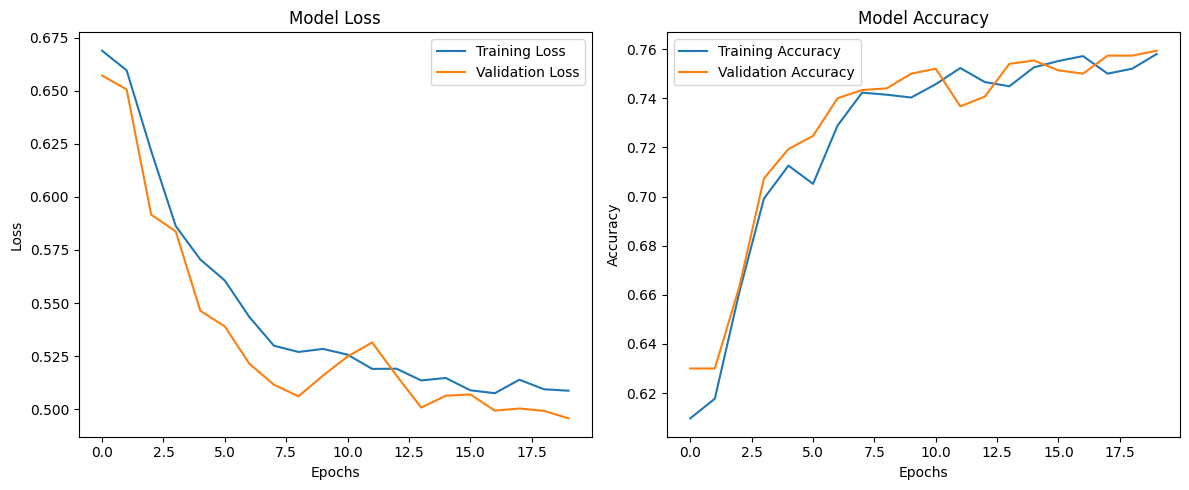

In [44]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


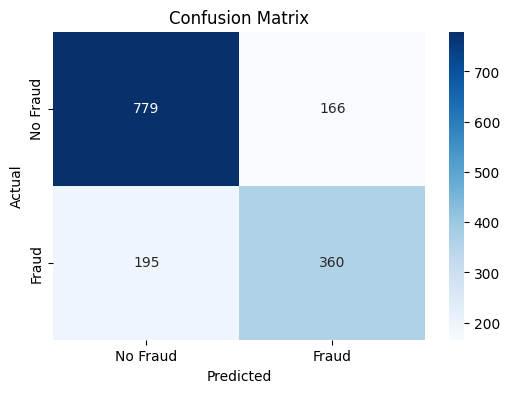

In [45]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

y_pred = model.predict(X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
plot_confusion_matrix(y_test, y_pred)

In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_test, (y_pred > 0.5).astype(int)))


              precision    recall  f1-score   support

           0       0.80      0.82      0.81       945
           1       0.68      0.65      0.67       555

    accuracy                           0.76      1500
   macro avg       0.74      0.74      0.74      1500
weighted avg       0.76      0.76      0.76      1500



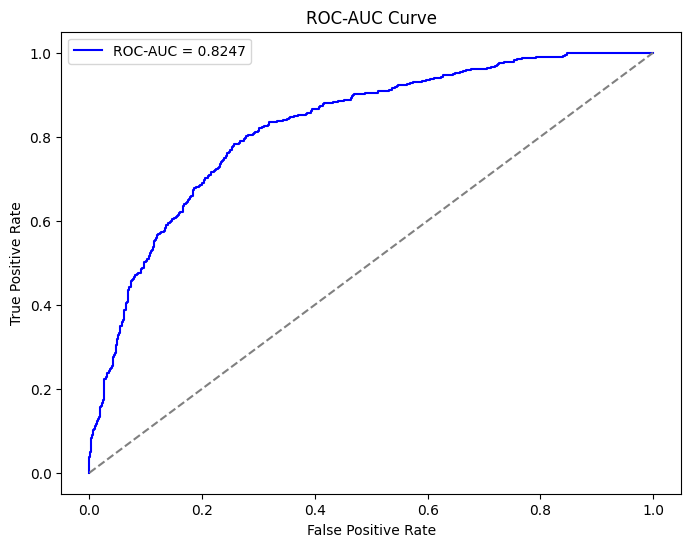

In [47]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC-AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend()
    plt.show()

plot_roc_auc(y_test, y_pred)